# Lab6.2 Emotional classification with an LLM

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

Through this notebook, you will annotate a text with an LLM. We will use here a small open source model [Qwen version 3:1.7b](https://huggingface.co/Qwen).

You will read a conversation and send the utterances to the Ollama server to annotate each using instructions, so-called prompting.  The code for the annotator is given in **llm_annotator.py**. It is an Ollama client that sends a prompt request to a Ollama server server to get a response.

We assume you have already installed ```ollama``` locally and pulled the models that you need to your local machine. See lab1 for more instructions.

## 1. Instantiating the annotator

We create an instance of the LLMAnnotator after importing the code.

In [1]:
from llm_annotator import LLMAnnotator

/opt/anaconda3/envs/hltenv/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


To instantiate an LLMAnnotator, we can give it three parameters:

1. the name of the model
2. the set of labels
3. some examples for the few-shot learning
4. the maximum amount of context to be considered for each utterance

As a model, we use here ```qwen3:1.7b```. This model needs to be available in your local ```ollama``` server. You can also try another model if it fits in your memory. Note that the script for the LLMAnnotator has some specific code to get the answer from the response. The Qwen model outputs its thinking as well surrounded by ```<think>...</think>```. Using another model may imply adapting the processing of the response.


In [2]:
model='qwen3:1.7b'
### Labels to try
sentiment_labels = ["positive", "negative", "neutral"]
ekman_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]
examples = [{"Input": "I love dogs", "Output": "joy"}, {"Input": "I hate cats", "Output": "disgust"}]
annotator = LLMAnnotator(model=model, labels=ekman_labels, examples=examples, max_context=5)

My instructions are: [{'role': 'system', 'content': 'You are an intelligent assistant.'}, {'role': 'system', 'content': 'You will receive utterances from a conversation as Input in JSON format.'}, {'role': 'system', 'content': 'You need to determine the emotion of the last utterance.'}, {'role': 'system', 'content': "Only use one of the following labels:['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']."}, {'role': 'system', 'content': 'Only determine the emotion of LAST utterance, use the preceding utterances as context.'}, {'role': 'system', 'content': 'Output the most appropriate label in JSON format.'}, {'role': 'system', 'content': 'Do not output anything else.'}, {'role': 'system', 'content': 'Here are a few examples:'}, {'role': 'user', 'content': 'I love dogs'}, {'role': 'system', 'content': 'joy'}, {'role': 'user', 'content': 'I hate cats'}, {'role': 'system', 'content': 'disgust'}]


We are now going to read the conversation that we created before with the LLM with our annotations and send these to the LLM to annotate.

In [6]:
import pandas as pd

annotation_file = "/Users/piek/Desktop/t-MA-HLT-introduction-2025/ma-hlt-labs/lab1.chat/annotation/chats_2025/adjudicated_annotations.json"

df = pd.read_json(annotation_file)
df.head()

,utterance,speaker,turn_id,Gold,Annotator,Votes,Annotators,Adjudication
0,Can you give me ideas on how to deal with some...,Bill,4,neutral,Rico,"[neutral, neutral, sadness, sadness, neutral, ...","[Rico, Ella, Vera Langeberg, Giulia, zia, Thom...",sadness
1,I am so angry. I am blind with rage. I want to...,Bill,6,anger,Rico,"[anger, anger, anger, anger, anger, anger]","[Rico, Ella, Vera Langeberg, Giulia, zia, Thom...",anger
2,But at the same time I am happy that it is ove...,Bill,8,joy,Rico,"[joy, joy, anger, anger, joy, joy]","[Rico, Ella, Vera Langeberg, Giulia, zia, Thom...",joy
3,When I found out I was so surprised. I saw no ...,Bill,10,surprise,Rico,"[surprise, surprise, surprise, surprise, surpr...","[Rico, Ella, Vera Langeberg, Giulia, zia, Thom...",surprise
4,Please do give me some steps to get over this,Bill,12,neutral,Rico,"[neutral, neutral, neutral, neutral, neutral, ...","[Rico, Ella, Vera Langeberg, Giulia, zia, Thom...",neutral


In [7]:
utterances = df["utterance"]
labels = df['Adjudication']
print(len(utterances))
print(len(labels))

604
604


We have 604 utterances and labels from the conversations. Prompting the LLM to annotate these will take a lot of time as it is slows. We will therefore only select a subset of the data. We use the ```annotate_conversation``` fucntion from the annotator to annotate the subset.

In [8]:
subset = 10
annotations = annotator.annotate_conversation(utterances[:subset])
print(annotations[:5])

Annotating a conversation with 10 utterances
Processed 5 in 67 seconds
Processed 5 turns in total out of 10
Processed 5 in 92 seconds
Processed 10 turns in total out of 10
[{'Input': 'Can you give me ideas on how to deal with someone cheating on you? I am going through all kinds of emotions. I am a wreck.', 'Output': 'sadness'}, {'Input': 'I am so angry. I am blind with rage. I want to break stuff!', 'Output': 'anger'}, {'Input': 'But at the same time I am happy that it is over. I deserve better! I am proud to leave that lying bastard! I am proud of listening to my gut and relizing that I do deserve more!', 'Output': '{  "emotion": "anger"}'}, {'Input': 'When I found out I was so surprised. I saw no clues. ', 'Output': 'surprise'}, {'Input': 'Please do give me some steps to get over this', 'Output': 'sadness'}]


First of all, note that a generative LLM is very slow, especially compared to an encoder model such as GO-BERT. An encoder represents the full texts in one go before generating the prediction for its classification head. A generative model does not use a classification head but needs to generate the next token at each step. So if it generates a response of ten tokens, it needs to represent the text ten times as well: once for each next token and increasingly as the response grows.

We could add the predictions from the LLM to the dataframe but LLMs do not always precisely follow the instructions e.g. "Output: Output:neutral". We therefore need to clean and filter the output. Specifically, we check if any of a Ekman label is a substring of the output and if so then take that value. If none of these is matched, we set the value to None.

In [10]:
llm_predicted_labels = []
for anno in annotations:
    ## By default the value is None
    llm_label = None
    if 'Output' in anno:
        prediction = anno['Output']
        for label in ekman_labels:
            if label in prediction:
                ### We found a valid label so we replace None by the label
                llm_label = label
    llm_predicted_labels.append(llm_label)
print('Clean list of predictions for the subset', llm_predicted_labels)

Clean list of predictions for the subset ['sadness', 'anger', 'anger', 'surprise', 'sadness', 'sadness', 'joy', 'sadness', 'sadness', 'sadness']


We can now take the adjudicated annotations for the same subset as the gold labels and generate a classification report.

In [11]:
adjudicated_labels = list(df['Adjudication'])[:subset]
print('Adjudicated labels for the subset', adjudicated_labels)

print(len(llm_predicted_labels), len(adjudicated_labels))
for gold, predict in zip(adjudicated_labels, llm_predicted_labels):
    print(gold, predict)

Adjudicated labels for the subset ['sadness', 'anger', 'joy', 'surprise', 'neutral', 'anger', 'joy', 'sadness', 'anger', 'anger']
10 10
sadness sadness
anger anger
joy anger
surprise surprise
neutral sadness
anger sadness
joy joy
sadness sadness
anger sadness
anger sadness


In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

label_set = set(adjudicated_labels+llm_predicted_labels)
report = classification_report(adjudicated_labels,llm_predicted_labels ,digits = 3, target_names=label_set)
print('LLM Ekman ----------------------------------------------------------------')

print(report)

LLM Ekman ----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness      0.500     0.250     0.333         4
    surprise      1.000     0.500     0.667         2
         joy      0.000     0.000     0.000         1
     neutral      0.333     1.000     0.500         2
       anger      1.000     1.000     1.000         1

    accuracy                          0.500        10
   macro avg      0.567     0.550     0.500        10
weighted avg      0.567     0.500     0.467        10



/opt/anaconda3/envs/hltenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/hltenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/hltenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

We can see that the results are not very good, which we could have guessed from the paired list of values: e.g. "sadness" is mostly assigned when it should not. 

Confusion matrix SVM
[[1 0 0 3 0]
 [1 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 2 0]
 [0 0 0 0 1]]


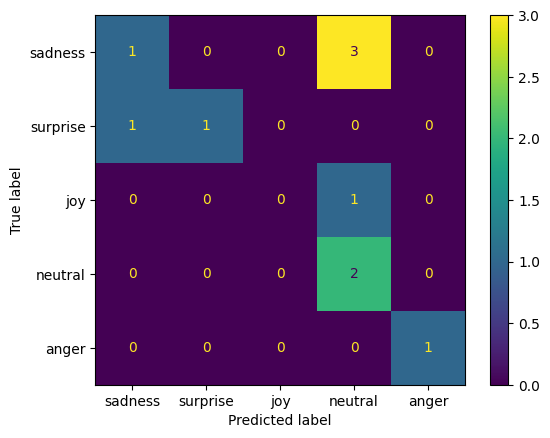

In [13]:
print('Confusion matrix SVM')
cf_matrix = confusion_matrix(adjudicated_labels,llm_predicted_labels)
print(cf_matrix)
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set)
display.plot()

## End of notebook